## Different LSTM and autoencoder approaches for encoding and k-means for clustering (MIT-BIH ECG data)

Inspiration from:
* https://github.com/navneetkr123/Clustering-using-deep-learning-LSTM-Autoencoder-Kmeans-/blob/master/switchon_new.ipynb

* https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

* https://blog.keras.io/building-autoencoders-in-keras.html

In [2]:
import numpy as np
import pandas as pd
import random

from sklearn.cluster import KMeans
from keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed
from keras.models import Model, Sequential

import matplotlib.pyplot as plt
import umap.umap_ as umap

### Data Loader, Cluster Selection & Irregularity

In [3]:
#load raw data

train_raw = np.loadtxt('data/mitbih_train.csv', delimiter=",",dtype=float)
test_raw = np.loadtxt('data/mitbih_test.csv',delimiter=",",dtype=float)

In [4]:
#shuffle rows
np.random.shuffle(train_raw)
np.random.shuffle(test_raw)

print("original size train: ", train_raw.shape)
print("original size test: ", test_raw.shape)

#reduce nr. of samples
train_small = train_raw[:-82554]
test_small = test_raw[:-20892]

print("small size train: ", train_small.shape)
print("small size test: ", test_small.shape)

#split to X and y
X_train = train_small[:, 0:-1]
y_train = train_small[:, -1]

X_test = test_small[:, 0:-1]
y_test = test_small[:, -1]

original size train:  (87554, 188)
original size test:  (21892, 188)
small size train:  (5000, 188)
small size test:  (1000, 188)


#### only 2 clusters

In [6]:
from sklearn.utils import resample

#select 2000 samples of the 2 classes with most samples (0 & 4)
df_1=train_raw[train_raw[:, 187]==0]
df_2=train_raw[train_raw[:, 187]==4]
df_1_upsample=resample(df_1,replace=True,n_samples=2000,random_state=123)
df_2_upsample=resample(df_2,replace=True,n_samples=2000,random_state=124)
print(len(df_1_upsample))
print(len(df_2_upsample))

X_train = np.concatenate([df_1_upsample, df_2_upsample])
np.random.shuffle(X_train)

X_train = X_train[:, 0:-1]
y_train = X_train[:, -1]

print(X_train)

2000
2000
[[0.91868132 0.86153847 0.79670328 ... 0.         0.         0.        ]
 [0.68051118 0.56389779 0.46166134 ... 0.         0.         0.        ]
 [0.73444611 0.61911988 0.49317148 ... 0.         0.         0.        ]
 ...
 [0.95613158 0.91824526 0.85942173 ... 0.         0.         0.        ]
 [0.94603711 0.93760538 0.83642495 ... 0.         0.         0.        ]
 [0.88612098 0.51601422 0.55516016 ... 0.         0.         0.        ]]


#### create irregular TS

In [ ]:
#check number of zeros in each row in original data (already irregular)
n_zeros = np.count_nonzero(X_train==0, axis=1)
print(n_zeros)

In [7]:
# TRAIN DATA
# random boolean mask for which values will be changed
replace_rate = 0.3
mask = np.random.choice([0, 1], size=X_train.shape, p=((1-replace_rate),replace_rate)).astype(np.bool)

# random matrix the same shape
r = np.zeros(shape=X_train.shape)

# use  mask to replace values in input array
X_train[mask] = r[mask]

# TEST DATA
mask_test = np.random.choice([0, 1], size=X_test.shape, p=((1-replace_rate),replace_rate)).astype(np.bool)
r_test = np.zeros(shape=X_test.shape)
X_test[mask_test] = r_test[mask_test]

/var/folders/1t/84sy00cj2qxfmggm20f9p_w00000gn/T/ipykernel_78480/2468837170.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.random.choice([0, 1], size=X_train.shape, p=((1-replace_rate),replace_rate)).astype(np.bool)
/var/folders/1t/84sy00cj2qxfmggm20f9p_w00000gn/T/ipykernel_78480/2468837170.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#depre

In [ ]:
n_zeros = np.count_nonzero(X_train==0, axis=1)
for i in n_zeros:
    print(i)

In [ ]:
#TODO check - I guess not needed
train = pd.DataFrame(X_train)
test = pd.DataFrame(X_test)
train.head(3)

In [ ]:
train = train.values
test = test.values

### Clustering Algorithms

#### SKlearn K-Means

In [8]:
def sklearnkmeans(encoded_data, n_clusters):
    kmeans = KMeans(n_clusters).fit(encoded_data)
    labels = kmeans.predict(encoded_data)

    centroids = kmeans.cluster_centers_

    return centroids, labels
    

#### DTW K-Means

In [9]:
def DTWDistance(s1, s2,w):
    DTW={}
    
    w = max(w, abs(len(s1)-len(s2)))
    
    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0
  
    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])
		
    return np.sqrt(DTW[len(s1)-1, len(s2)-1])

def k_means_dtw(data,num_clust,num_iter,w=5):
    centroids=random.sample(list(data),num_clust)
    counter=0
    for n in range(num_iter):
        counter+=1
        print(counter)
        assignments={}
        labels = []

        #assign data points to clusters
        for ind,i in enumerate(data):
            min_dist=float('inf')
            closest_clust=None
            for c_ind,j in enumerate(centroids):
                cur_dist=DTWDistance(i,j,w)
                if cur_dist<min_dist:
                    min_dist=cur_dist
                    closest_clust=c_ind
            if closest_clust in assignments:
                assignments[closest_clust].append(ind)
            else:
                assignments[closest_clust]=[]
            labels.append(closest_clust)
    
        #recalculate centroids of clusters
        for key in assignments:
            clust_sum=0
            for k in assignments[key]:
                clust_sum=clust_sum+data[k]
            centroids[key]=[m/len(assignments[key]) for m in clust_sum]
    
    return centroids, labels

#### clustering on original data

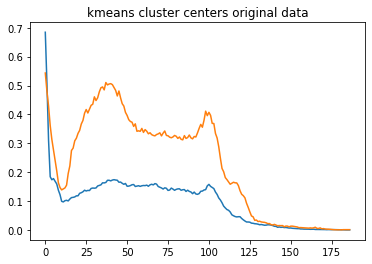

In [10]:
centroids, kmeans_labels = sklearnkmeans(X_train, n_clusters=2)

for i in centroids:
    plt.plot(i)
plt.title("kmeans cluster centers original data")
plt.show()

1
2
3
4
5


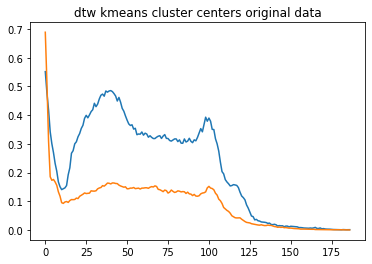

In [12]:
centroids, dtwkmeans_labels = k_means_dtw(X_train,num_clust=2,num_iter=5,w=5)

for i in centroids:
    plt.plot(i)
plt.title("dtw kmeans cluster centers original data")
plt.show()

### UMAP Embeddings 
(UMAP as a preprocessing step for clustering)

Uniform Manifold Approximation and Projection (UMAP) -  projects the high-dimensional data points into 2D/3D by inducing the projected data to have a similar distribution as the original data points by minimizing the KL divergence.

UMAP Documentation: https://umap-learn.readthedocs.io/en/latest/clustering.html 

* n_neighbors: controls how UMAP balances local versus global structure in the data - low values of n_neighbors will force UMAP to concentrate on very local structure 
* min_dist: controls how tightly UMAP is allowed to pack points together - minimum distance apart that points are allowed to be in the low dimensional representation - low values result in clumpier embeddings
* n_components: determine the dimensionality of the reduced dimension space we will be embedding the data into
* metric: how distance is computed in the ambient space of the input data (euclidean, manhattan, chebyshev, minkowski)

In [13]:
def umapt(data):
    umap_2d = umap.UMAP(n_components=2, init='random', random_state=42)
    #umap_3d = UMAP(n_components=3, init='random', random_state=0)

    proj_2d = umap_2d.fit_transform(data)

    return proj_2d

In [14]:
reducer = umap.UMAP(n_components=2)
umap_embedding = reducer.fit_transform(X_train)
umap_embedding.shape

(4000, 2)

Text(0.5, 1.0, 'Embedding of the training set by UMAP')

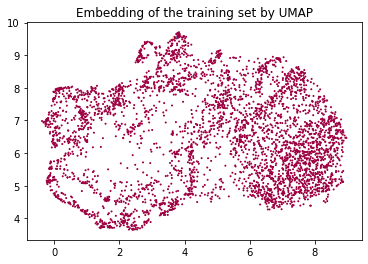

In [18]:
plt.scatter(umap_embedding[:,0], umap_embedding[:,1], s=1, c=y_train, cmap='Spectral')
plt.title('Embedding of the training set by UMAP')

#### clustering on umap embeddings

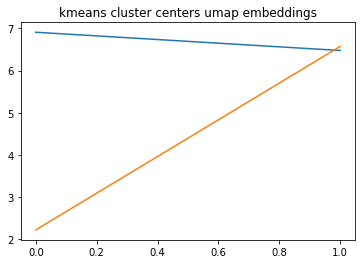

In [23]:
centroids, kmeans_labels = sklearnkmeans(umap_embedding, n_clusters=2)

for i in centroids:
    plt.plot(i)
plt.title("kmeans cluster centers umap embeddings")
plt.show()

1
2
3
4
5


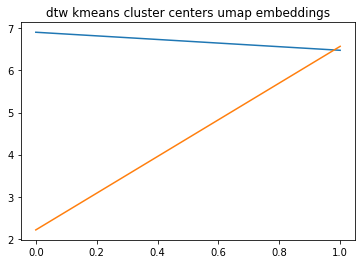

In [24]:
centroids, dtwkmeans_labels = k_means_dtw(umap_embedding,num_clust=2,num_iter=5,w=5)

for i in centroids:
    plt.plot(i)
plt.title("dtw kmeans cluster centers umap embeddings")
plt.show()

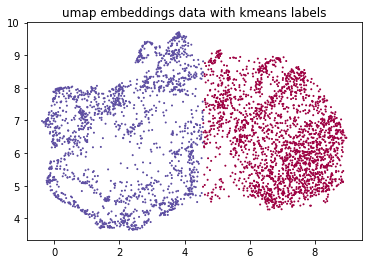

In [21]:
plt.title("umap embeddings data with kmeans labels")
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=kmeans_labels, s=1, cmap='Spectral')

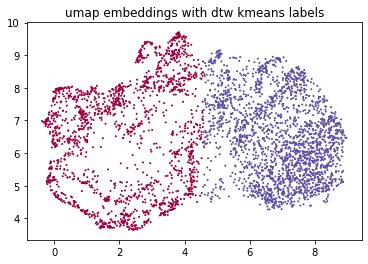

In [22]:
plt.title("umap embeddings with dtw kmeans labels")
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=dtwkmeans_labels, s=1, cmap='Spectral')

### LSTM


#### LSTM Model & Training

* We are using return_sequences=True in all the LSTM layers. That means, each layer is outputting a 2D array containing each timesteps.
* Thus, there is no one-dimensional encoded feature vector as output of any intermediate layer. --> Therefore, encoding a sample into a feature vector is not happening.
* Absence of this encoding vector differentiates the regular LSTM network for reconstruction from an LSTM Autoencoder.

https://towardsdatascience.com/step-by-step-understanding-lstm-autoencoder-layers-ffab055b6352

##### only needed for sequence prediction

In [26]:
#only needed for prediction
def temporalize(X, y, lookback):
    '''
    Inputs
    X         A 2D numpy array ordered by time of shape: (n_observations x n_features)
    lookback  The window size to look back in the past records. Shape: a scalar.

    Output
    output_X  A 3D numpy array of shape: ((n_observations-lookback-1) x lookback x  n_features)
    output_y  A 1D array of shape: (n_observations-lookback-1), aligned with X.
    '''
    output_X = []
    output_y = []
    for i in range(len(X)-lookback-1):
        t = []
        for j in range(1,lookback+1):
            # Gather past records upto the lookback period
            t.append(X[[(i+j+1)], :])
        output_X.append(t)
        output_y.append(y[i+lookback+1])
    return output_X, output_y

In [41]:
##only needed for prediction
# reshape to fit in lstm - need n_samples x timesteps x n_features

X_train_t = X_train.transpose()
X_test_t = X_test.transpose()

n_features = X_train_t.shape[1]
n_features_test = X_test_t.shape[1]

print("timpesteps orig: ", X_train_t.shape[0])
print("features: ", n_features)

# Temporalize the data - needed to predict sequences
timesteps = 5

X_train_lstm, y_train_lstm = temporalize(X = X_train_t, y=np.zeros(len(X_train_t)), lookback = timesteps)
X_test_lstm, y_test_lstm = temporalize(X = X_test_t, y=np.zeros(len(X_test_t)), lookback = timesteps)



timpesteps orig:  187
features:  4000


In [42]:
#reshape for LSTM
X_train_lstm = np.array(X_train_lstm)
X_train_lstm = X_train_lstm.reshape(X_train_lstm.shape[0], timesteps, n_features)
X_test_lstm = np.array(X_test_lstm)
X_test_lstm = X_test_lstm.reshape(X_test_lstm.shape[0], timesteps, n_features_test)
y_train_lstm = np.array(y_train_lstm)
y_test_lstm = np.array(y_test_lstm)

print("X train: ", X_train_lstm.shape)
print("y train: ", y_train_lstm.shape)

X train:  (181, 5, 4000)
y train:  (181,)


##### LSTM for now

In [63]:
#reshape for LSTM - need n_samples x timesteps x n_features
X_train_lstm = np.reshape(np.array(X_train), (4000, 187, 1))
#X_test_lstm = np.reshape(np.array(X_test), (X_test[0], X_test[1], -1))
y_train_lstm = np.array(y_train)
#y_test_lstm = np.array(y_test_lstm)

print("X train: ", X_train_lstm.shape)
print("y train: ", y_train_lstm.shape)

X train:  (4000, 187, 1)
y train:  (4000,)


In [64]:
# define model
model = Sequential()
model.add(LSTM(10, activation='relu', input_shape=(timesteps,n_features), return_sequences=True))
model.add(LSTM(5, activation='relu', return_sequences=True))
model.add(LSTM(10, activation='relu', return_sequences=True)) #each LSTM unit returning a sequence of 187 outputs,
model.add(TimeDistributed(Dense(n_features))) # need to configure last LSTM layer prior to  TimeDistributed wrapped Dense layer to return sequences
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 5, 10)             160440    
                                                                 
 lstm_7 (LSTM)               (None, 5, 5)              320       
                                                                 
 lstm_8 (LSTM)               (None, 5, 10)             640       
                                                                 
 time_distributed_2 (TimeDis  (None, 5, 4000)          44000     
 tributed)                                                       
                                                                 
Total params: 205,400
Trainable params: 205,400
Non-trainable params: 0
_________________________________________________________________


In [65]:
history_lstm_seq = model.fit(X_train_lstm, X_train_lstm, epochs=10,
          batch_size=16,
          shuffle=True)


Epoch 1/10


ValueError: in user code:

    File "/usr/local/lib/python3.9/site-packages/keras/engine/training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.9/site-packages/keras/engine/training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.9/site-packages/keras/engine/training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.9/site-packages/keras/engine/training.py", line 808, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.9/site-packages/keras/engine/input_spec.py", line 263, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_2" is incompatible with the layer: expected shape=(None, 5, 4000), found shape=(16, 187, 1)


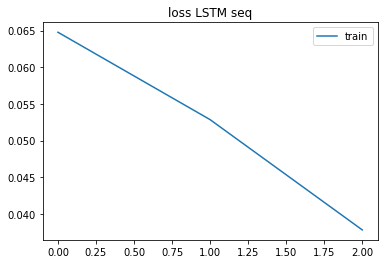

In [31]:
plt.plot(history_lstm_seq.history['loss'], label='train')
#plt.plot(history_lstm_seq.history['val_loss'], label='test')
plt.title("loss LSTM seq")
plt.legend()
plt.show()

In [35]:
#no encoding
#predicts a sequence --> not needed for now

predicted_lstm_seq = model.predict(X_train_lstm) 
print(predicted_lstm_seq.shape)
predicted_lstm_seq = predicted_lstm_seq.transpose()
print(predicted_lstm_seq.shape)
predicted_lstm_seq = np.reshape(predicted_lstm_seq, (4000, 187))


(181, 5, 4000)
(4000, 5, 181)


ValueError: cannot reshape array of size 3620000 into shape (4000,187)

#### Clustering

In [34]:
centroids, kmeans_labels = sklearnkmeans(predicted_lstm_seq, n_clusters=2)

#plot centroids
for i in centroids:
    plt.plot(i)
plt.title("kmean cluster centers lstm")
plt.show()

ValueError: Found array with dim 3. Estimator expected <= 2.

In [ ]:
centroids, labels_dtwkmeans=k_means_dtw(predicted_lstm_seq,num_clust=5,num_iter=10,w=5)

for i in centroids:
    plt.plot(i)
plt.title("dtw kmeans cluster centers lstm embeddings")
plt.show()

In [ ]:
umap_2d = umapt(predicted_lstm_seq)
plt.title("umap on lstm embeddings with original labels")
plt.scatter(umap_2d[:, 0], umap_2d[:, 1], c=y_test, s=0.1, cmap='Spectral')

In [ ]:
plt.title("umap on lstm embeddings with kmeans labels")
plt.scatter(umap_2d[:, 0], umap_2d[:, 1], c=kmeans_labels, s=0.1, cmap='Spectral')

In [ ]:
plt.title("umap on lstm embeddings with dtw kmeans labels")
plt.scatter(umap_2d[:, 0], umap_2d[:, 1], c=dtwkmeans_labels, s=0.1, cmap='Spectral')

## Autoencoder

In [70]:
train = pd.DataFrame(X_train)
test = pd.DataFrame(X_test)

train = train.values
test = test.values

### Simple Autoencoder

#### Model & Training of Embeddings

In [71]:
# size of encoded representation
encoding_dim = 10
#input sequence
input = Input(shape=(187,))
# encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input)
# lossy reconstruction of the input
decoded = Dense(187, activation='sigmoid')(encoded)

In [72]:
autoencoder = Model(input, decoded)

In [73]:
# This model maps an input to its encoded representation
encoder_ac = Model(input, encoded)
# This is our encoded input
encoded_input_ac = Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer_ac = autoencoder.layers[-1]
# Create the decoder model
decoder_ac = Model(encoded_input_ac, decoder_layer_ac(encoded_input_ac))

In [78]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

history_ac  = autoencoder.fit(train, train,
                epochs=500,
                batch_size=16,
                shuffle=True,
                validation_data=(test, test))

Epoch 1/500
250/250 [==============================] - 1s 1ms/step - loss: 0.4760 - val_loss: 0.4874
Epoch 2/500
250/250 [==============================] - 0s 1ms/step - loss: 0.4755 - val_loss: 0.4868
Epoch 3/500
250/250 [==============================] - 0s 1ms/step - loss: 0.4749 - val_loss: 0.4862
Epoch 4/500
250/250 [==============================] - 0s 2ms/step - loss: 0.4743 - val_loss: 0.4856
Epoch 5/500
250/250 [==============================] - 0s 947us/step - loss: 0.4737 - val_loss: 0.4849
Epoch 6/500
250/250 [==============================] - 0s 881us/step - loss: 0.4730 - val_loss: 0.4843
Epoch 7/500
250/250 [==============================] - 0s 908us/step - loss: 0.4724 - val_loss: 0.4836
Epoch 8/500
250/250 [==============================] - 0s 886us/step - loss: 0.4717 - val_loss: 0.4829
Epoch 9/500
250/250 [==============================] - 0s 905us/step - loss: 0.4710 - val_loss: 0.4822
Epoch 10/500
250/250 [==============================] - 0s 900us/step - loss: 0.4

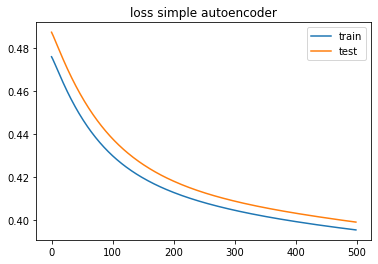

In [79]:
plt.plot(history_ac.history['loss'], label='train')
plt.plot(history_ac.history['val_loss'], label='test')
plt.title("loss simple autoencoder")
plt.legend()
plt.show()

In [80]:
encoded_data_ac = encoder_ac.predict(test)
print(encoded_data_ac.shape)
decoded_data_ac = decoder_ac.predict(encoded_data_ac)

(1000, 10)


#### Clustering

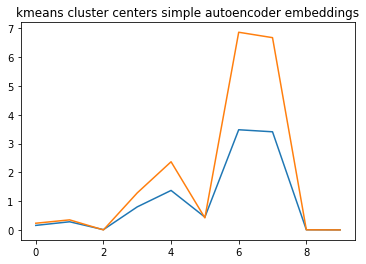

In [82]:
centroids, kmeans_labels = sklearnkmeans(encoded_data_ac, n_clusters=2)

#plot centroids
for i in centroids:
    plt.plot(i)
plt.title("kmeans cluster centers simple autoencoder embeddings")
plt.show()

1
2
3
4
5
6
7
8
9
10


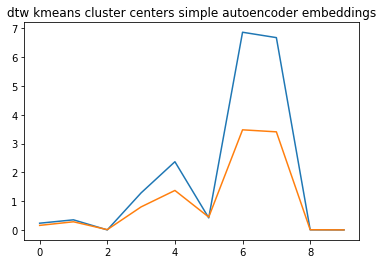

In [83]:
centroids, dtwkmeans_labels =k_means_dtw(encoded_data_ac,num_clust=2,num_iter=10,w=5)

for i in centroids:
    plt.plot(i)
plt.title("dtw kmeans cluster centers simple autoencoder embeddings")
plt.show()

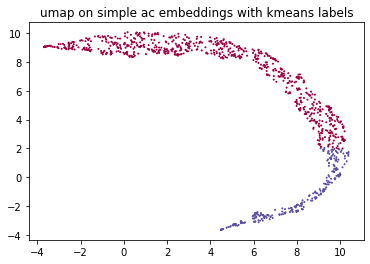

In [85]:
plt.title("umap on simple ac embeddings with kmeans labels")
plt.scatter(umap_2d[:, 0], umap_2d[:, 1], c=kmeans_labels, s=1, cmap='Spectral')

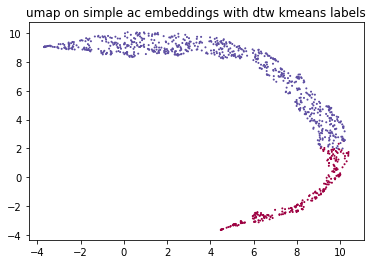

In [86]:
plt.title("umap on simple ac embeddings with dtw kmeans labels")
plt.scatter(umap_2d[:, 0], umap_2d[:, 1], c=dtwkmeans_labels, s=1, cmap='Spectral')

### Deep Autoencoder

#### Model & Training of Embeddings

In [87]:
input = Input(shape=(187,))

encoded = Dense(128, activation='relu')(input)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)
encoded = Dense(16, activation='relu')(encoded)

decoded = Dense(32, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(decoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(187, activation='sigmoid')(decoded)

In [88]:
autoencoder_deep = Model(input, decoded)

# This model maps an input to its encoded representation
encoder_ac_deep = Model(input, encoded)
encoded_input_ac_deep = Input(shape=(187,))
#decoder_layer_ac_deep = autoencoder_deep.layers[-1]
#decoder_ac_deep = Model(encoded_input_ac_deep, decoder_layer_ac_deep(encoded_input_ac_deep))

In [89]:
autoencoder_deep.compile(optimizer='adam', loss='binary_crossentropy')

history_ac_deep = autoencoder_deep.fit(train, train,
                epochs=200,
                batch_size=16,
                shuffle=True,
                validation_data=(test, test))

Epoch 1/200
250/250 [==============================] - 1s 3ms/step - loss: 0.3688 - val_loss: 0.3032
Epoch 2/200
250/250 [==============================] - 0s 2ms/step - loss: 0.3156 - val_loss: 0.2873
Epoch 3/200
250/250 [==============================] - 0s 2ms/step - loss: 0.3044 - val_loss: 0.2786
Epoch 4/200
250/250 [==============================] - 0s 2ms/step - loss: 0.2999 - val_loss: 0.2742
Epoch 5/200
250/250 [==============================] - 0s 2ms/step - loss: 0.2964 - val_loss: 0.2715
Epoch 6/200
250/250 [==============================] - 1s 2ms/step - loss: 0.2937 - val_loss: 0.2693
Epoch 7/200
250/250 [==============================] - 1s 2ms/step - loss: 0.2918 - val_loss: 0.2674
Epoch 8/200
250/250 [==============================] - 1s 2ms/step - loss: 0.2906 - val_loss: 0.2666
Epoch 9/200
250/250 [==============================] - 1s 2ms/step - loss: 0.2895 - val_loss: 0.2653
Epoch 10/200
250/250 [==============================] - 0s 2ms/step - loss: 0.2886 - val_lo

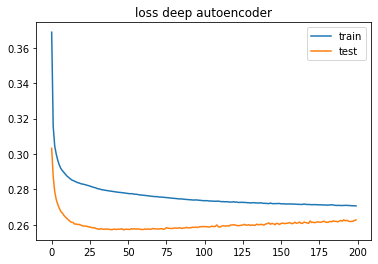

In [90]:
plt.plot(history_ac_deep.history['loss'], label='train')
plt.plot(history_ac_deep.history['val_loss'], label='test')
plt.title("loss deep autoencoder")
plt.legend()
plt.show()

In [91]:
encoded_data_ac_deep = encoder_ac_deep.predict(test)
#decoded_data_ac_deep = decoder_ac.predict(encoded_data_ac_deep)

#### Clustering

In [ ]:
centroids, kmeans_labels = sklearnkmeans(encoded_data_ac_deep, n_clusters=2)

#plot centroids
for i in centroids:
    plt.plot(i)
plt.title("kmean cluster centers deep autoencoder embeddings")
plt.show()

In [ ]:
centroids, dtwkmeans_labels = k_means_dtw(encoded_data_ac_deep,num_clust=2,num_iter=10,w=5)

for i in centroids:
    plt.plot(i)
plt.title("dtw kmeans cluster centers deep autoencoder embeddings")
plt.show()

In [ ]:
umap_2d = umapt(encoded_data_ac_deep)
plt.title("umap on deep ac embeddings with original labels")
plt.scatter(umap_2d[:, 0], umap_2d[:, 1], c=y_test, s=1, cmap='Spectral')

In [ ]:
plt.title("umap on deep ac embeddings with kmeans labels")
plt.scatter(umap_2d[:, 0], umap_2d[:, 1], c=kmeans_labels, s=1, cmap='Spectral')

In [ ]:
plt.title("umap on deep ac embeddings with dtw kmeans labels")
plt.scatter(umap_2d[:, 0], umap_2d[:, 1], c=dtwkmeans_labels, s=1, cmap='Spectral')

### LSTM autoencoder

#### Model & Training of Embeddings

https://towardsdatascience.com/lstm-autoencoder-for-extreme-rare-event-classification-in-keras-ce209a224cfb 


https://blog.keras.io/building-autoencoders-in-keras.html

To build a LSTM-based autoencoder, first use a LSTM encoder to turn your input sequences into a single vector that contains information about the entire sequence, then repeat this vector n times (where n is the number of timesteps in the output sequence), and run a LSTM decoder to turn this constant sequence into the target sequence.

In [ ]:
#reshape to fit in lstm - need n_samples x timesteps/lookback x n_features

timesteps = 187
n_features = 1
X_train_t = X_train.transpose()
X_test_t = X_test.transpose()
train_lstm = X_train_t.reshape(-1, timesteps, 1)
test_lstm = X_test_t.reshape(-1, timesteps, 1)


print(train_lstm.shape)
print(X_train_t.shape)

In [ ]:
lstm_autoencoder = Sequential()
# Encoder
lstm_autoencoder.add(LSTM(30, activation='relu', input_shape=(timesteps, n_features), return_sequences=True))
lstm_autoencoder.add(LSTM(10, activation='relu', return_sequences=False))
lstm_autoencoder.add(RepeatVector(timesteps))
# Decoder
lstm_autoencoder.add(LSTM(10, activation='relu', return_sequences=True))
lstm_autoencoder.add(LSTM(30, activation='relu', return_sequences=True))
lstm_autoencoder.add(TimeDistributed(Dense(n_features)))


In [ ]:
lstm_autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
#lstm_autoencoder.build(train_lstm.shape)
lstm_autoencoder.summary()

In [ ]:

lstm_ac_history = lstm_autoencoder.fit(train_lstm, train_lstm, 
                                                epochs=30, 
                                                batch_size=16, 
                                                validation_data=(test_lstm, test_lstm),
                                                verbose=2)

In [ ]:
plt.plot(lstm_ac_history.history['loss'], label='train')
plt.plot(lstm_ac_history.history['val_loss'], label='test')
plt.title("loss lstm autoencoder")
plt.legend()
plt.show()

#### Clustering

In [ ]:
encoded_data_ac_lstm = lstm_autoencoder.predict(train_lstm)
print(encoded_data_ac_lstm.shape)
encoded_data_ac_lstm = encoded_data_ac_lstm.reshape(-1, 187)
print(encoded_data_ac_lstm.shape)

In [ ]:
centroids, kmeans_labels = sklearnkmeans(encoded_data_ac_lstm, n_clusters=2)

#plot centroids
for i in centroids:
    plt.plot(i)
plt.title("kmean cluster centers lstm autoencoder embeddings")
plt.show()

In [ ]:
centroids, dtwkmeans_labels = k_means_dtw(encoded_data_ac_lstm,num_clust=5,num_iter=10,w=5)

for i in centroids:
    plt.plot(i)
plt.title("dtw kmeans cluster centers lstm autoencoder embeddings")
plt.show()

In [ ]:
umap_2d = umapt(encoded_data_ac_lstm)
plt.title("umap on lstm ac embeddings with original labels")
plt.scatter(umap_2d[:, 0], umap_2d[:, 1], c=y_train, s=0.1, cmap='Spectral')

In [ ]:
plt.title("umap on lstm ac embeddings with kmeans labels")
plt.scatter(umap_2d[:, 0], umap_2d[:, 1], c=kmeans_labels, s=0.1, cmap='Spectral')

In [ ]:
plt.title("umap on simple ac embeddings with dtw kmeans labels")
plt.scatter(umap_2d[:, 0], umap_2d[:, 1], c=dtwkmeans_labels, s=0.1, cmap='Spectral')